# Imports

In [ ]:
!pip3 install imbalanced-learn==0.9.0
!pip3 install scikit-learn==1.0.1
!pip3 install xgboost
!pip install costcla==0.6
import sys

import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns
import os
import sklearn.preprocessing
from sklearn.svm import SVC
from costcla.metrics import cost_loss
from typing import Tuple, List, Union
from pandas import DataFrame
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import EasyEnsembleClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import NearMiss
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

# Prepare Dataset


Create a dataframe which contains x, y, z and anomaly label

In [ ]:
FEATURES = ["x", "y", "z", "anomaly"]

def get_files(directory_path: str) -> List[str]:
    all_files = []
    for subdirectories, directories, files in os.walk(directory_path):
        for file in files:
            if file.find('.csv') != -1:
                all_files.append(os.path.join(subdirectories, file))
    return all_files


def get_frames(filelist: List[str], columns: Union[List[int], None],
                              seperator: str = ",") -> List[
    DataFrame]:
    dataframes = []
    for i in range(len(filelist)):
        if not columns:
            series = pd.read_csv(filelist[i], header=0, sep=seperator)
            series = series.drop(series.columns[0], axis=1)
        else:
            series = pd.read_csv(filelist[i], usecols=columns, header=0, sep=seperator)
        dataframes.append(series)
    dataframes = min_max_scaling(dataframes)
    return dataframes

def min_max_scaling(frames: List[DataFrame]) -> List[DataFrame]:
    scaler = sklearn.preprocessing.MinMaxScaler()
    for i, frame in enumerate(frames):
        for column in frame:
            if frame[column].dtype == np.float64 or frame[column].dtype == np.int64:
                scaler.fit(np.array(frame[column]).reshape(-1, 1))
                frame[column] = scaler.fit_transform(frame[[column]])
    return frames

def get_sum_anomalies_info(frames: List[DataFrame]) -> int:
    sum = 0
    anomalies = 0
    normal = 0
    for frames in frames:
        sum += len(frames)
        anomalies += frames.anomaly.value_counts()[1]
        normal += frames.anomaly.value_counts()[0]
    return sum, anomalies, normal

def join_frames(frames: List[DataFrame]) -> DataFrame:
    result = pd.concat(frames)
    assert result is not None
    return result

def train_model(model, model_name):
    print(model_name)
    model = model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print('Classification Report')
    print(classification_report(y_test, pred))


# Loading

In [ ]:
# load the file paths
train_paths = get_files('data/train')
test_paths = get_files('data/test')
# load the data in pandas
train_frames = get_frames(train_paths, columns=FEATURES)
test_frames = get_frames(test_paths, columns=FEATURES)
# assert loading is done
assert len(train_frames) == 20
assert len(test_frames) == 5

# Exploration

maybe some plots instead of print

In [ ]:
# basic info
train_count, train_anomaly_count, train_normal_count = get_sum_anomalies_info(train_frames)
test_count, test_anomaly_count, test_normal_count = get_sum_anomalies_info(test_frames)

# distribution info
train_normal_dist = round((train_count - train_anomaly_count) / train_count, 3)
test_normal_dist = round((test_count - test_anomaly_count) / test_count, 3)
train_anomaly_dist = round(train_anomaly_count / train_count, 3)
test_anomaly_dist = round(test_anomaly_count / test_count, 3)

# output info
print(f"\n training samples => \n\t overall: {train_count}, \n\t normal: {train_normal_count}, \n\t anomalous: {train_anomaly_count}")
print(f"\n training distribution => \n\t normal: {train_normal_dist}, \n\t anomalous: {train_anomaly_dist}")
print(f"\n testing samples => \n\t overall: {test_count}, \n\t normal: {test_normal_count}, \n\t anomalous: {test_anomaly_count}")
print(f"\n testing distribution => \n\t normal: {test_normal_dist}, \n\t anomalous: {test_anomaly_dist}")


 training samples => 
	 overall: 134229, 
	 normal: 127656, 
	 anomalous: 6573

 training distribution => 
	 normal: 0.951, 
	 anomalous: 0.049

 testing samples => 
	 overall: 30030, 
	 normal: 28420, 
	 anomalous: 1610

 testing distribution => 
	 normal: 0.946, 
	 anomalous: 0.054


In [ ]:
# get the second frame
train_example = train_frames[1]
test_example = test_frames[1]

**Visualizing**

In [ ]:
# configure seaborn
sns.set(rc={'figure.figsize':(12, 6)})
sns.set_theme()
sns.set_style("dark")

Text(0.5, 1.0, 'Training Example Frame')

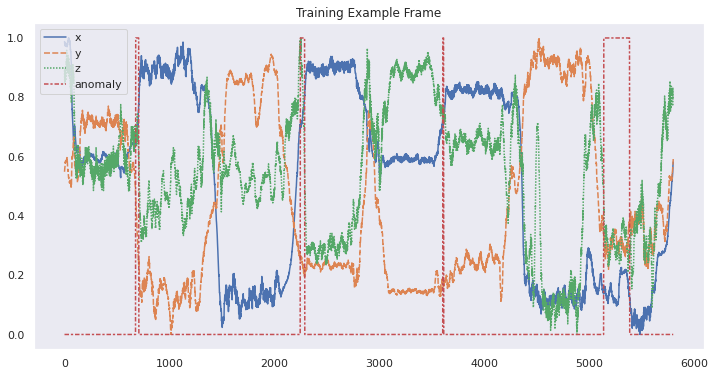

In [ ]:
sns.lineplot(data=train_example).set_title('Training Example Frame')

Text(0.5, 1.0, 'Testing Example Frame')

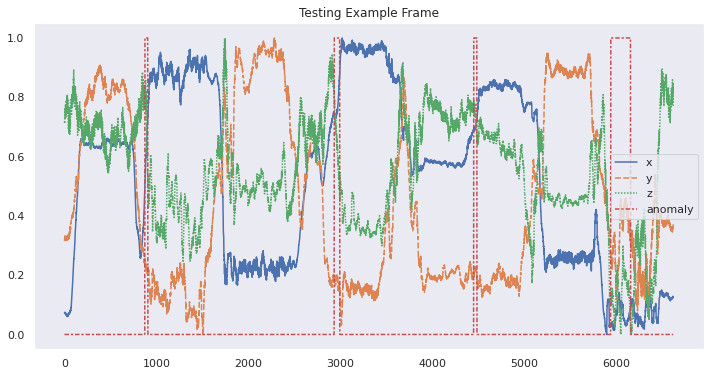

In [ ]:
sns.lineplot(data=test_example).set_title('Testing Example Frame')

# Preprocessing


Join the frames to train and test

In [ ]:
train = join_frames(train_frames)
test = join_frames(test_frames)
print("Training shape: ", train.shape)
print("Testing shape: ", test.shape)

Training shape:  (134229, 4)
Testing shape:  (30030, 4)


Visualize random sample

In [ ]:
chart = alt.Chart(train.sample(n=100)).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color='anomaly:N'
).properties(
    width=150,
    height=150
).repeat(
    row=['x', 'y', 'z'],
    column=['z', 'y', 'x']
).interactive()
chart

alt.RepeatChart(...)

# Split to train and test set

In [ ]:
X_train = train.drop(columns=["anomaly"], axis=1)
y_train = train["anomaly"]
X_test = test.drop(columns=["anomaly"], axis=1)
y_test = test["anomaly"]

# Training with imbalance



In [ ]:
nb = MultinomialNB(alpha = 0)
train_model(nb, 'Naive Bayes')

Naive Bayes
Classification Report
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     28420
         1.0       0.00      0.00      0.00      1610

    accuracy                           0.95     30030
   macro avg       0.47      0.50      0.49     30030
weighted avg       0.90      0.95      0.92     30030



In [ ]:
dt = DecisionTreeClassifier(criterion ='entropy', max_depth = 1)
train_model(dt, 'Decision Tree')

Decision Tree
Classification Report
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     28420
         1.0       0.00      0.00      0.00      1610

    accuracy                           0.95     30030
   macro avg       0.47      0.50      0.49     30030
weighted avg       0.90      0.95      0.92     30030



In [ ]:
lr = LogisticRegression(solver="lbfgs")
train_model(lr, 'Logistic Regression')

Logistic Regression
Classification Report
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     28420
         1.0       0.25      0.00      0.01      1610

    accuracy                           0.95     30030
   macro avg       0.60      0.50      0.49     30030
weighted avg       0.91      0.95      0.92     30030



In [ ]:
svc = SVC(C = 0.62, gamma = 0.08)
train_model(svc, 'SVC')

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
train_model(knn, 'KNN')

In [ ]:
xgb = XGBClassifier(n_estimators = 1500, nthread  = 4, max_depth = 15, min_child_weight = 5, learning_rate=0.01)
train_model(xgb, 'XGBClassifier')

XGBClassifier
Classification Report
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96     28420
         1.0       0.29      0.24      0.26      1610

    accuracy                           0.93     30030
   macro avg       0.63      0.60      0.61     30030
weighted avg       0.92      0.93      0.92     30030



In [ ]:
rfc = RandomForestClassifier(n_estimators = 1500, n_jobs=-1, max_depth=15, 
                             min_samples_split=5, min_samples_leaf=3)
train_model(rfc, 'Random Forest Classifier')

Random Forest Classifier
Classification Report
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97     28420
         1.0       0.30      0.18      0.22      1610

    accuracy                           0.93     30030
   macro avg       0.62      0.58      0.59     30030
weighted avg       0.92      0.93      0.93     30030



# Cost Sensitive Learning


Create a classic cost-matrix

In [ ]:
cost_m = [[0, 1], [5, 0]]

Check how many examples are positive and how many are negative regarding fall events.
From dataset: normal (0) and fall accident (1).
Now, we will replace Normal with (1) and fall accident with (0).

In [ ]:
y_train_cs = y_train.map({1: 0, 0: 1})
y_test_cs = y_test.map({1: 0, 0: 1})

y_test_cs_count = y_test_cs.value_counts()
y_train_cs_count = y_train_cs.value_counts()

print(y_test_cs_count, '\n')
print(y_train_cs_count)

1    28420
0     1610
Name: anomaly, dtype: int64 

1    127656
0      6573
Name: anomaly, dtype: int64


Methods to minimize the expected cost


In [ ]:
def cost_sensitive(y_test, X_train, y_train, X_test):
    # 1 is fall, 0 is normal

    clf = RandomForestClassifier(n_estimators=100, random_state=0)
    print("without sampling")
    print(Counter(y_train))
    # 1: 127656, 0: 6573

    model = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(classification_report(y_test, y_pred))
    conf_m = confusion_matrix(y_test, y_pred).T  # transpose to align with slides
    print(conf_m)
    loss = np.sum(conf_m * cost_m)
    print("%d\n" % loss)

   
    print("with undersampling")
    sampler = RandomUnderSampler(sampling_strategy={0: 6573, 1: 6235}, random_state=1)
    X_rs, y_rs = sampler.fit_resample(X_train, y_train)
    print(Counter(y_rs))

    model = clf.fit(X_rs, y_rs)
    y_pred = clf.predict(X_test)

    print(classification_report(y_test, y_pred))
    conf_m = confusion_matrix(y_test, y_pred).T  # transpose to align with slides
    print(conf_m)
    loss = np.sum(conf_m * cost_m)
    print("%d\n" % loss)

    print("with oversampling")
    sampler = RandomOverSampler(sampling_strategy={0: 134576, 1: 127656}, random_state=1)
    X_rs, y_rs = sampler.fit_resample(X_train, y_train)
    print(Counter(y_rs))

    model = clf.fit(X_rs, y_rs)
    y_pred = clf.predict(X_test)

    print(classification_report(y_test, y_pred))
    conf_m = confusion_matrix(y_test, y_pred).T  # transpose to align with slides
    print(conf_m)
    loss = np.sum(conf_m * cost_m)
    print("%d\n" % loss)

    print("with combination")
    sampler = RandomUnderSampler(sampling_strategy={0: 5801, 1: 5502}, random_state=1)
    X_rs, y_rs = sampler.fit_resample(X_train, y_train)
    sampler = RandomOverSampler(sampling_strategy={0: 140500, 1: 122000}, random_state=1)
    X_rs, y_rs = sampler.fit_resample(X_rs, y_rs)
    print(Counter(y_rs))

    model = clf.fit(X_rs, y_rs)
    y_pred = clf.predict(X_test)

    print(classification_report(y_test, y_pred))
    conf_m = confusion_matrix(y_test, y_pred).T  # transpose to align with slides
    print(conf_m)
    loss = np.sum(conf_m * cost_m)
    print("%d\n" % loss)
    # fp, fn, tp, tn
    fp = np.full((y_test.shape[0], 1), 5)
    fn = np.full((y_test.shape[0], 1), 1)
    tp = np.zeros((y_test.shape[0], 1))
    tn = np.zeros((y_test.shape[0], 1))
    cost_matrix = np.hstack((fp, fn, tp, tn))
    
    print("without weights")
    model = clf.fit(X_train, y_train)
    pred_test = model.predict(X_test)

    print(classification_report(y_test, pred_test))
    conf_m = confusion_matrix(y_test, pred_test).T  # transpose to align with slides
    print(conf_m)
    loss = np.sum(conf_m * cost_m)
    print("%d\n" % loss)

    print("\nwith weights")
    clf = RandomForestClassifier(n_estimators=10, random_state=0, class_weight={0: 5, 1: 1})
    model = clf.fit(X_train, y_train)
    pred_test = model.predict(X_test)

    print(classification_report(y_test, pred_test))
    conf_m = confusion_matrix(y_test, pred_test).T # transpose to align with slides
    print(conf_m)
    loss = np.sum(conf_m * cost_m)
    print("%d\n" %loss)

In [ ]:
cost_sensitive(y_test_cs, X_train, y_train_cs, X_test)


without sampling
Counter({1: 127656, 0: 6573})
              precision    recall  f1-score   support

           0       0.27      0.22      0.24      1610
           1       0.96      0.97      0.96     28420

    accuracy                           0.93     30030
   macro avg       0.61      0.59      0.60     30030
weighted avg       0.92      0.93      0.92     30030

[[  360   984]
 [ 1250 27436]]
7234

with undersampling
Counter({0: 6573, 1: 6235})
              precision    recall  f1-score   support

           0       0.20      0.75      0.32      1610
           1       0.98      0.83      0.90     28420

    accuracy                           0.83     30030
   macro avg       0.59      0.79      0.61     30030
weighted avg       0.94      0.83      0.87     30030

[[ 1205  4750]
 [  405 23670]]
6775

with oversampling
Counter({0: 134576, 1: 127656})
              precision    recall  f1-score   support

           0       0.26      0.27      0.27      1610
           1       

# Class Imbalance Approaches

**Near Miss**

In [ ]:
# Create a pipeline for Logistic Regression
pipeline = make_pipeline(NearMiss(version=1),
                         LogisticRegression(solver="lbfgs"))
pipeline.fit(X_train, y_train)

# Classify and report the results
print("logistic regression with near miss 1")
print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))

logistic regression with near miss 1
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.97      0.57      0.69      0.72      0.63      0.39     28420
        1.0       0.08      0.69      0.57      0.15      0.63      0.40      1610

avg / total       0.92      0.57      0.69      0.68      0.63      0.39     30030



In [ ]:
# Create a pipeline for Random Forest
pipeline = make_pipeline(NearMiss(version=1),
                         RandomForestClassifier(n_estimators = 1500, n_jobs=-1, max_depth=15, 
                             min_samples_split=5, min_samples_leaf=3))
pipeline.fit(X_train, y_train)

# Classify and report the results
print("Random Forest with near miss 1")
print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))

Random Forest with near miss 1
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.96      0.29      0.80      0.45      0.48      0.22     28420
        1.0       0.06      0.80      0.29      0.11      0.48      0.25      1610

avg / total       0.92      0.32      0.78      0.43      0.48      0.22     30030



In [ ]:
# Create a pipeline for Naive Bayes
pipeline = make_pipeline(NearMiss(version=1),
                         MultinomialNB( alpha = 0))
pipeline.fit(X_train, y_train)

# Classify and report the results
print("Naive Bayes with near miss 1")
print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))

Naive Bayes with near miss 1
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.96      0.42      0.69      0.59      0.54      0.29     28420
        1.0       0.06      0.69      0.42      0.12      0.54      0.30      1610

avg / total       0.91      0.44      0.68      0.56      0.54      0.29     30030



In [ ]:
# Create a pipeline for XGboost
pipeline = make_pipeline(NearMiss(version=1),
                         XGBClassifier(n_estimators = 1500, nthread  = 4, max_depth = 15, min_child_weight = 5, learning_rate=0.01))
pipeline.fit(X_train, y_train)

train_model(xgb, 'XGBClassifier')
# Classify and report the results
print("Naive Bayes with near miss 1")
print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))

XGBClassifier
Classification Report
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96     28420
         1.0       0.29      0.24      0.26      1610

    accuracy                           0.93     30030
   macro avg       0.63      0.60      0.61     30030
weighted avg       0.92      0.93      0.92     30030

Naive Bayes with near miss 1
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.97      0.30      0.82      0.45      0.49      0.23     28420
        1.0       0.06      0.82      0.30      0.12      0.49      0.26      1610

avg / total       0.92      0.32      0.79      0.44      0.49      0.23     30030



**SMOTE**

In [ ]:
# Create a pipeline
pipeline = make_pipeline(SMOTE(random_state=3, k_neighbors=6),
                         LogisticRegression(solver="lbfgs"))
pipeline.fit(X_train, y_train)
# Classify and report the results
print("logistic regression with SMOTE")
print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))

logistic regression with SMOTE
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.98      0.77      0.72      0.86      0.74      0.56     28420
        1.0       0.15      0.72      0.77      0.25      0.74      0.55      1610

avg / total       0.94      0.76      0.73      0.83      0.74      0.56     30030



In [ ]:
# Create a pipeline
pipeline = make_pipeline(SMOTE(random_state=3, k_neighbors=6),
                          RandomForestClassifier(n_estimators = 1500, n_jobs=-1, max_depth=15, 
                             min_samples_split=5, min_samples_leaf=3))
pipeline.fit(X_train, y_train)
# Classify and report the results
print("Random Forest with SMOTE")
print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))

Random Forest with SMOTE
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.98      0.87      0.62      0.92      0.73      0.55     28420
        1.0       0.21      0.62      0.87      0.31      0.73      0.53      1610

avg / total       0.93      0.85      0.64      0.88      0.73      0.55     30030



In [ ]:
# Create a pipeline
pipeline = make_pipeline(SMOTE(random_state=3, k_neighbors=6),
                          MultinomialNB( alpha = 0))
pipeline.fit(X_train, y_train)
# Classify and report the results
print("Naive Bayes with SMOTE")
print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))

Naive Bayes with SMOTE
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.93      0.51      0.31      0.66      0.39      0.16     28420
        1.0       0.03      0.31      0.51      0.06      0.39      0.15      1610

avg / total       0.88      0.50      0.32      0.62      0.39      0.16     30030



In [ ]:
# Create a pipeline
pipeline = make_pipeline(SMOTE(random_state=3, k_neighbors=6),
                          XGBClassifier(n_estimators = 1500, nthread  = 4, max_depth = 15, min_child_weight = 5, learning_rate=0.01))
pipeline.fit(X_train, y_train)
# Classify and report the results
print("XGB Classifier with SMOTE")
print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))

XGB Classifier with SMOTE
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.97      0.89      0.51      0.93      0.67      0.47     28420
        1.0       0.21      0.51      0.89      0.30      0.67      0.44      1610

avg / total       0.93      0.87      0.53      0.90      0.67      0.47     30030



**Easy Ensemble**

In [ ]:
base_estimator = LogisticRegression(solver="lbfgs")
eec = EasyEnsembleClassifier(n_estimators=10, base_estimator=base_estimator)
eec.fit(X_train, y_train)

# Classify and report the results
print("Logistic Regression with Easy Ensemble")
print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))

Logistic Regression with Easy Ensemble
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.97      0.89      0.51      0.93      0.67      0.47     28420
        1.0       0.21      0.51      0.89      0.30      0.67      0.44      1610

avg / total       0.93      0.87      0.53      0.90      0.67      0.47     30030



In [ ]:
base_estimator = MultinomialNB( alpha = 0)
eec = EasyEnsembleClassifier(n_estimators=10, base_estimator=base_estimator)
eec.fit(X_train, y_train)

# Classify and report the results
print("Naive Bayes with Easy Ensemble")
print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))

Naive Bayes with Easy Ensemble
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.97      0.89      0.51      0.93      0.67      0.47     28420
        1.0       0.21      0.51      0.89      0.30      0.67      0.44      1610

avg / total       0.93      0.87      0.53      0.90      0.67      0.47     30030



In [ ]:
base_estimator = RandomForestClassifier(n_estimators = 1500, n_jobs=-1, max_depth=15, 
                             min_samples_split=5, min_samples_leaf=3)
eec = EasyEnsembleClassifier(n_estimators=10, base_estimator=base_estimator)
eec.fit(X_train, y_train)

# Classify and report the results
print("Random Forest with Easy Ensemble")
print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. Th

/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubundums/anaconda3/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. Th

Random Forest with Easy Ensemble
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.97      0.89      0.51      0.93      0.67      0.47     28420
        1.0       0.21      0.51      0.89      0.30      0.67      0.44      1610

avg / total       0.93      0.87      0.53      0.90      0.67      0.47     30030



In [ ]:
base_estimator = XGBClassifier(n_estimators = 1500, nthread  = 4, max_depth = 15, min_child_weight = 5, learning_rate=0.01)
eec = EasyEnsembleClassifier(n_estimators=10, base_estimator=base_estimator)
eec.fit(X_train, y_train)

# Classify and report the results
print("XGB Classifier with Easy Ensemble")
print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))

XGB Classifier with Easy Ensemble
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.97      0.89      0.51      0.93      0.67      0.47     28420
        1.0       0.21      0.51      0.89      0.30      0.67      0.44      1610

avg / total       0.93      0.87      0.53      0.90      0.67      0.47     30030



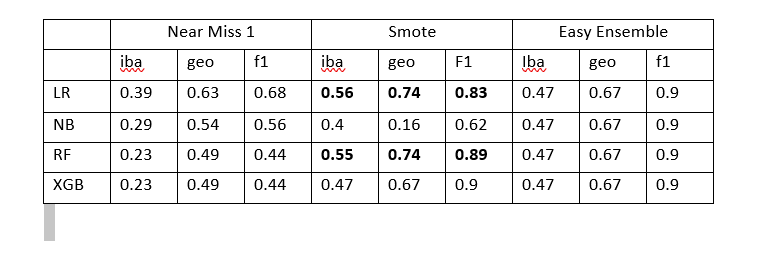